## A. Importing relevant libraries

In [1]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
from src.cleanfuncs import *
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

## B. Data transformation

### 0. Importar data

An input is requested to determine whether the data transformation process should be sensible to the special features of the testing compared to the training one. If 'train' is entered as key, or no key is entered at all  the data processing will follow the train path, while test key will employ the test flow. Both are largely the same, with the main difference that the test flow takes care of not reshaping the file to ensure is compatible with the  competition's format.

In [2]:
key = input()
if key == '':
    fullset = pd.read_csv('train.csv')
elif key == 'train':
    fullset = pd.read_csv('train.csv')
elif key == 'test':
    fullset = pd.read_csv('test.csv')
else:
    print('Tipo de datos no seleccionado')

### 1. Amenities 

The transformation in the cell below (which was disabled as it did not meet the criteria to be included in the modeling set) extracted relevant information from the 'Amenities' column of the dataset. The amenities selected were those which exhibited the highest correlation with the objective variable.

In [3]:
#import collections
#import re
#
#total_amenities = []
#for i in fullset.amenities:
#    RE = re.findall('"[^"]+"', i)
#    for e in RE:
#        total_amenities.append(e)        
#occurrences = collections.Counter(total_amenities)
#occurrences
#A = {k: v for k, v in sorted(occurrences.items(), key=lambda item: item[1])}
#B = list(A.keys())
#
#Amen_dum = ['"Oven"', '"Indoor fireplace"', '"Green Soap shampoo"', '"24\\"', 
#            '"Dryer"', '"High chair"', '"Bathtub"', '"Kitchen"', '"Dishwasher"', '"Lock on bedroom door"']
#
##en este for, escoger entre Amen_dum o B para sacar todas las dummies, o solo las altamente correlacionadas
#for i in Amen_dum:
#    g = []
#    for e in range(len(fullset)):
#        if i in fullset.loc[e,'amenities']:
#            g.append(1)
#        else:
#            g.append(0)
#    fullset[i] = g
#
#

### 2. Removing outliers

Outliers from the 'price' variable are deleted below.

In [4]:
if key == 'train':
    fullset = fullset[fullset['price']<1000]
    fullset = fullset[fullset['price']>0]
elif key == '':
    fullset = fullset[fullset['price']<1000]
    fullset = fullset[fullset['price']>0]
else:
    pass

### 3. 'Entire' dummy 

A dummy variable is created taking a value of 1 if the 'property_type' column contains the word 'entire' and 0 otherwise.

In [5]:
Entire = []
count = 0

for i in fullset['property_type']:
    if 'Entire' in i:
        Entire.append(1)
        count += 1
    else:
        Entire.append(0)

print(count)

fullset['entire'] = Entire

2608


### 4. Room-Acc Interact

Creating a term of interaction between the variables 'bedrooms' and 'accomodates'.

In [6]:
# -- Cobb 1/2
fullset['sizeinteract'] = (fullset['bedrooms']**(1/2))*(fullset['accommodates']**(1/2))


### 5. Review Dummies

Review-related columns manually transformed into dummies.

In [7]:
ratings = fullset[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]

ratings = ratings.fillna(ratings.mean())

ratings['mean_score'] = ratings.mean(axis=1)

fullset['mean_score'] = StandardScaler().fit_transform(ratings['mean_score'].values.reshape(-1, 1))
fullset['cleanliness'] = ratings['review_scores_cleanliness']


#Stack Gordo
fullset['scores_rating'] = ratings[ 'review_scores_rating']
fullset['scores_accuracy'] = ratings[ 'review_scores_accuracy']
fullset['scores_cleanliness'] = ratings[ 'review_scores_cleanliness']
fullset['scores_checkin'] = ratings[ 'review_scores_checkin']
fullset['scores_communication'] = ratings['review_scores_communication' ]
fullset['scores_location'] = ratings[ 'review_scores_location']
fullset['scores_value'] = ratings[ 'review_scores_value']

### 6. Superhost dummy

Dummy variable transforming 'host_is_superhost' values from t/f to binary 1/0.

In [8]:
superh = []
for i in fullset['host_is_superhost']:
    A = tf_01(i)
    superh.append(A)     
fullset['superhost'] = superh

### 7. New bathroom variable

An ad-hoc built function is employed to clean de bathroom 'column' and make it usable. This function extract the number of banthroms and ponderates the obtained value depending on whether the bathroom is shared or not, and its equipment.

In [9]:
fullset.bathrooms_text.fillna('0', inplace=True)
newbath = []
for i in list(fullset.bathrooms_text):
    A = bathroom_cleanse(i)
    newbath.append(A)    
fullset['bathnum'] = newbath

### 8. Extracting info from coordinates

Employing the coordinates provided in the dataset, the distance of each housing option to a point that represent the city center (which as been selected according to housing costs data and real estate market data from external sources) is computed and added as a new column to the dataset. Moreover, a dummy variable is created transforming the continous data on distance to the center to a discrete one telling whether it is located in the city center or in the outskirts.

In [10]:
cleanset = clean10_mercat(fullset)
cleanset['distance'] = distance(cleanset)
meguardoladistancia = cleanset['distance']
outk = []
for i in cleanset['distance']:
    outk.append(geobinary(i))
cleanset['outskirts'] = outk

### 9. Roomtype dummies

Generating dummies for the four different values that the 'roomtype' column can take.

In [11]:
cleanset['roomtype'] = roomtype()
DummiesA = pd.get_dummies(cleanset['roomtype'])
cleanset['Entire_home/apt'] = DummiesA['Entire home/apt']
cleanset['Private_room'] = DummiesA['Private room']
cleanset['Shared_room'] = DummiesA['Shared room']
cleanset['Hotel_room'] = DummiesA['Hotel room']
cleanset = cleanset.drop('roomtype', axis=1)


### 10. Bath-Acc-Bed Interact

In the cell below different interaction terms with multiple weights are computed to account for the influence over prices of the number of bathrooms and the different metrics for accomodation capacity and size.

In [12]:
# -- Vainilla
cleanset['Bath_interact'] = cleanset['bathnum']*cleanset['accommodates'] 

# -- Cobb 1/2
cleanset['Bath_interact1_1'] = (cleanset['bathnum']**(1/2))*(cleanset['accommodates']**(1/2)) 

# -- Cobb 2/3 - 1/3
cleanset['Bath_interact2_1'] = (cleanset['bathnum']**(1/3))*(cleanset['accommodates']**(2/3))

#-- Cobb 1/3 - 1/3 - 1/3
cleanset['Bath_interact_1_1_1'] = (cleanset['bathnum']**(1/3))*(cleanset['accommodates']**(1/3))*(cleanset['bedrooms']**(1/3))

cleanset['Bath_ratio'] = cleanset['bathnum']/cleanset['accommodates'] # -- Bath Ratio
#cleanset = cleanset.drop('accommodates', axis=1)
#cleanset = cleanset.drop('bathnum', axis=1)

### 11. Removing other numeric columns

Some numeric columns which are deemed irrelevant are removed from the set.

In [13]:
cleanset = cleanset.drop(['host_listings_count', 'maximum_nights', 'minimum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'availability_365', 'beds', 'latitude', 'longitude'], axis=1)

#Se ha dropeado beds por estar altamente correlacionado con accomodates, la corr no llegaba al 90% pero se acercaba mucho

### 12. Distance-Size Interact

Generating an interaction term between the distance to the city center and the size of the housing.

In [14]:
cleanset['distance'] = meguardoladistancia
if key == '':
    cleanset = cleanset[cleanset['distance']<75]
# -- Cobb 1/2
cleanset['dist_size_inter'] = (cleanset['sizeinteract']**(1/2))*(cleanset['distance']**(1/2))

### 13. Managing NaNs

Null values are managed in the cell below depending on the selected flow (train or test).

In [15]:
if key == 'train':
    print(cleanset.isna().sum())
    cleanset.dropna(inplace=True)
    print(cleanset.isna().sum())
    
elif key == '':
    print(cleanset.isna().sum())
    cleanset.dropna(inplace=True)
    print(cleanset.isna().sum())
    
elif key == 'test':
    print(cleanset.isna().sum())
    cleanset['sizeinteract'].fillna(cleanset['sizeinteract'].mean(),inplace=True)
    cleanset['Bath_interact'].fillna(cleanset['sizeinteract'].mean(),inplace=True)
    cleanset['dist_size_inter'].fillna(cleanset['sizeinteract'].mean(),inplace=True)
    cleanset['Bath_interact_1_1_1'].fillna(cleanset['Bath_interact_1_1_1'].mean(),inplace=True)
    print(cleanset.isna().sum())

accommodates              0
bedrooms                200
price                     0
entire                    0
sizeinteract            200
mean_score                0
cleanliness               0
scores_rating             0
scores_accuracy           0
scores_cleanliness        0
scores_checkin            0
scores_communication      0
scores_location           0
scores_value              0
superhost                 0
bathnum                   0
distance                  0
outskirts                 0
Entire_home/apt           0
Private_room              0
Shared_room               0
Hotel_room                0
Bath_interact             0
Bath_interact1_1          0
Bath_interact2_1          0
Bath_interact_1_1_1     200
Bath_ratio                0
dist_size_inter         200
dtype: int64
accommodates            0
bedrooms                0
price                   0
entire                  0
sizeinteract            0
mean_score              0
cleanliness             0
scores_rating        

## C. Variable selector

The cell below plays the role of control panel of the model. By placing hashtags on the cell below columns can be included/excluded from the dataset in a flexible and agile manner. Each code line drops a variable from the code, thus finally included variables are those whose associated code line is preceded by a hashtag.

In [16]:
############################################## - Main Ones 

#cleanset = cleanset.drop('bathnum', axis=1)
#cleanset = cleanset.drop('Entire_home/apt', axis=1)
cleanset = cleanset.drop('Bath_ratio', axis=1)
#cleanset = cleanset.drop('cleanliness', axis=1)
#cleanset = cleanset.drop('sizeinteract', axis=1)

############################################## - Others

cleanset = cleanset.drop('accommodates', axis=1)
cleanset = cleanset.drop('bedrooms', axis=1)
cleanset = cleanset.drop('superhost', axis=1)
cleanset = cleanset.drop('distance', axis=1)
cleanset = cleanset.drop('outskirts', axis=1)
cleanset = cleanset.drop('Private_room', axis=1)
cleanset = cleanset.drop('Shared_room', axis=1)
cleanset = cleanset.drop('Hotel_room', axis=1)
cleanset = cleanset.drop('Bath_interact', axis=1)
cleanset = cleanset.drop('mean_score', axis=1)
cleanset = cleanset.drop('dist_size_inter', axis=1)
cleanset = cleanset.drop('entire', axis=1)

############################################## - Scores Stack

cleanset = cleanset.drop('scores_rating', axis=1)
cleanset = cleanset.drop('scores_accuracy', axis=1)
cleanset = cleanset.drop('scores_cleanliness', axis=1)
cleanset = cleanset.drop('scores_checkin', axis=1)
cleanset = cleanset.drop('scores_communication', axis=1)
cleanset = cleanset.drop('scores_location', axis=1)
cleanset = cleanset.drop('scores_value', axis=1)

############################################## - Interactions

#cleanset = cleanset.drop('Bath_interact_1_1_1', axis=1)
#cleanset = cleanset.drop('Bath_interact2_1', axis=1)
#cleanset = cleanset.drop('Bath_interact1_1', axis=1)


## D. Some relevant fatures

The cells below provide different pieces of information which are relevant to get a grasp of the final product after the dataset have been shaped.

In [17]:
cleanset.columns

Index(['price', 'sizeinteract', 'cleanliness', 'bathnum', 'Entire_home/apt',
       'Bath_interact1_1', 'Bath_interact2_1', 'Bath_interact_1_1_1'],
      dtype='object')

In [18]:
if key == 'train':
    print(cleanset.corr().price)
else:
    pass

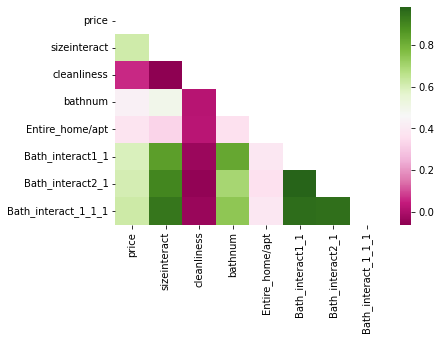

In [19]:
corrMatrix = cleanset.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
sn.heatmap(corrMatrix, mask=mask, cmap="PiYG")
plt.show()

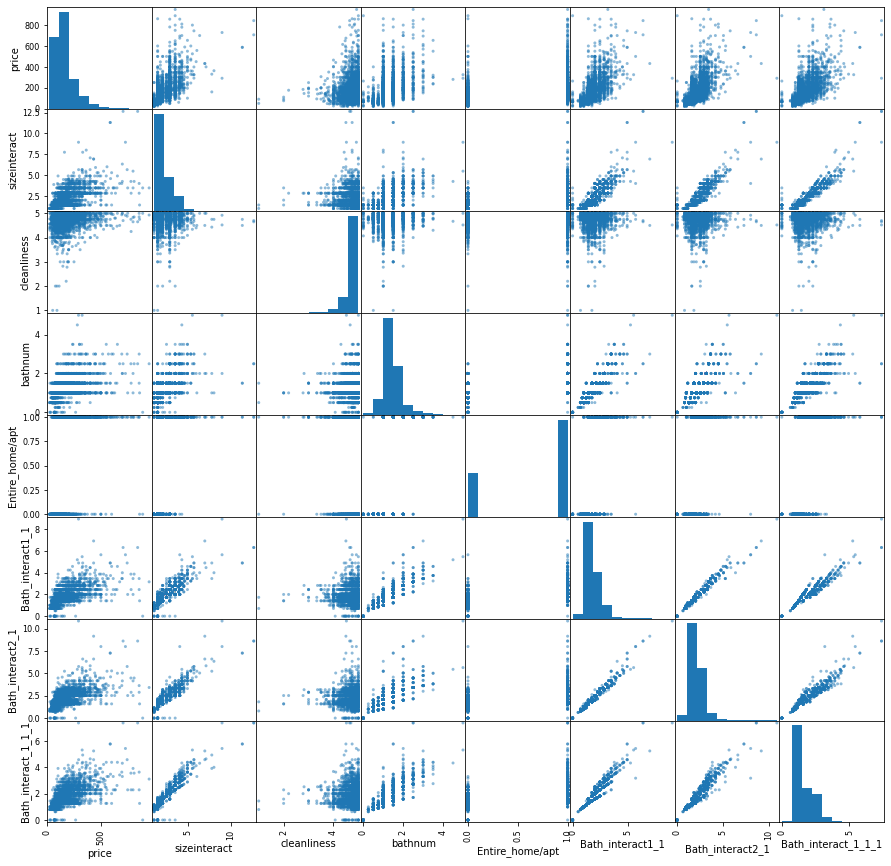

In [20]:
pd.plotting.scatter_matrix(cleanset, figsize=(15,15));

## E. Packaging and exporting of the data

In [21]:
if key == 'train':
    cleanset.to_csv('paket.csv')
    cleanset.to_csv('paket_h2o.csv')
elif key == 'test':
    cleanset.to_csv('paket_test.csv')
elif key == '':
    cleanset.to_csv('paket.csv')
    cleanset.to_csv('paket_h2o.csv')

## F. Empaquetado y exportación - H2O ready

In [22]:
from sklearn.model_selection import train_test_split as tts

In [23]:
if key == 'test':
    pass
else:
    paket = pd.read_csv('paket.csv')

    X=paket.drop('price', axis=1)
    y=paket.price

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

### G. [Extra] Amenities column related code

This code does not play an active role in the shaping of the dataset but is included here as extra information. ALl the shaping is included in the cells above, jointly with pakaging and exporting.

In [24]:
cleanset.isna().sum()

price                  0
sizeinteract           0
cleanliness            0
bathnum                0
Entire_home/apt        0
Bath_interact1_1       0
Bath_interact2_1       0
Bath_interact_1_1_1    0
dtype: int64

In [25]:
#fullset = fullset.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
#       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
#       'host_name', 'host_since', 'host_location', 'host_about',
#       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
#       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
#       'host_neighbourhood', 'host_listings_count',
#       'host_total_listings_count', 'host_verifications',
#       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
#       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
#       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
#       'bathrooms_text', 'bedrooms', 'beds', 'amenities',
#       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
#       'maximum_minimum_nights', 'minimum_maximum_nights',
#       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
#       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
#       'availability_30', 'availability_60', 'availability_90',
#       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
#       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
#       'last_review', 'review_scores_rating', 'review_scores_accuracy',
#       'review_scores_cleanliness', 'review_scores_checkin',
#       'review_scores_communication', 'review_scores_location',
#       'review_scores_value', 'license', 'instant_bookable',
#       'calculated_host_listings_count',
#       'calculated_host_listings_count_entire_homes',
#       'calculated_host_listings_count_private_rooms',
#       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'], axis=1)
#L = fullset.corr()['price']
#L

In [26]:
#P =dict(L)
#C = {k: v for k, v in sorted(P.items(), key=lambda item: item[1])}
#C

In [27]:
#Great = [k for k,v in C.items() if v >= 0.1]
#Tiny =  [k for k,v in C.items() if v <= -0.1]
#print(Great)
#print(Tiny)
#
#Amen_dum = ['"Oven"', '"Indoor fireplace"', '"Green Soap shampoo"', '"24\\"', 
#            '"Dryer"', '"High chair"', '"Bathtub"', '"Kitchen"', '"Dishwasher"', '"Lock on bedroom door"']